In [ ]:
using Revise
ENV["GKS_ENCODING"]="utf-8"

using LinearAlgebra, Statistics, Rotations, ProgressMeter, Random, JLD2, BenchmarkTools, StaticArrays, Dates, FileIO, Colors, NearestNeighbors, Distances, Distributions, FileWatching, Combinatorics, Dates, StatsBase, DelimitedFiles, DataStructures, SpecialFunctions, StatsFuns, Interpolations, Glob, IterTools, Hungarian, Clustering, Optim, Suppressor, ThreadsX, PrettyTables, Accessors

import Chemfiles as cf
import Humanize: digitsep

BLAS.set_num_threads(4)

using GLMakie, CairoMakie
gl(args...; kwargs...) = GLMakie.activate!(args...; kwargs...);
cairo(args...; kwargs...) = CairoMakie.activate!(args...; kwargs...);
set_theme!(resolution = (1000,800), fontsize=20);
set_window_config!(float=false);
ProgressMeter.ijulia_behavior(:clear)

import REPL
REPL.REPLCompletions.latex_symbols["\\fig"] = "fig = Figure(); ax = Axis(fig[1,1])";
REPL.REPLCompletions.latex_symbols["\\angstrom"] = "Å";

In [ ]:
using CUDA
CUDA.allowscalar(false)
import NPhotons as nph
includet("pdb.jl")
includet("plotutils.jl")

# 1EJG

## Stage 1

In [29]:
@load "out/images/ewald/1EJG/params.jld2" object N wavelength
rmask = [0.25]
nmask = [4]
kwidth = 2.0
radius = 0.8

files = glob("out/images/ewald/1EJG/1EJG*.jld2")[1:1]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files), nselect = 1000)

object = [nph.smoothen(object, kwidth)]
lfs = [nph.AtomVolume(1, 10.0, 30)]

proposers = (nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
    nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
    nph.WidthProposer(0.001)), 1
)),)

state = nph.Annealer(([0.1nph.randomAtomVolume(12, 3.2, 30)], [1.0]), proposers, temperature = 1e6, thalf = 1e3)
targetTemp = 1e-3

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 47)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);


@save "jobs/crambin/stage1.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth

Progress: 100%|███████████████████████████| Time: 0:00:00 (22.08 μs/it)
  selected:  1,000 = 11.6%
  total:     8,596


## Stage 2

In [242]:
@load "out/images/ewald/1EJG/params.jld2" object N wavelength
rmask = [0.33, 0.5]
nmask = [3, 2]
kwidth = 1.5
radius = 1.0

files = glob("out/images/ewald/1EJG/1EJG*.jld2")[1:10]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files), nselect = 20000)

object = [nph.smoothen(object, kwidth)]
lfs = load("jobs/crambin/out/stage1.jld2", "state").configuration[1]

proposers = (nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
    nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
    nph.WidthProposer(0.001)), 1
)),)

state = nph.Annealer(([0.1nph.randomAtomVolume(23, 2.3, 30)], [1.0]), proposers, temperature = 1e6, thalf = 1e4)
targetTemp = 1.0
totalsteps = nph.remainingSteps(state) * 3 ÷ 2

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 47)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);

# @save "jobs/crambin2/stage2asd.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

Progress: 100%|██████████████████████████▉|  ETA: 0:00:00 ( 3.80 μs/it)
  selected:  19,247 = 0.193%
  total:     9,970,141

## Stage 3

Progress: 100%|███████████████████████████| Time: 0:00:09 ( 3.21 μs/it)
  selected:  10,000 = 0.328%
  total:     3,044,813


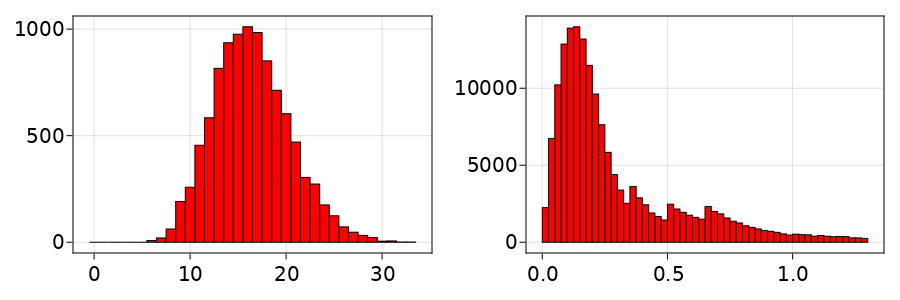

In [98]:
@load "out/images/ewald/1EJG/params.jld2" object N wavelength
rmask = [0.35, 0.5, 0.65]
nmask = [1, 1, 2]
kwidth = 1.2
radius = 1.3

files = glob("out/images/ewald/1EJG/1EJG*.jld2")
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files), nselect = 10000);

object = [nph.smoothen(object, kwidth)]
lfs = load("jobs/crambin2/out/stage2.jld2", "state").configuration[1]

proposers = (nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
    nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
    nph.WidthProposer(0.001)), 1
)),)

state = nph.Annealer(([0.1nph.randomAtomVolume(46, 1.9, 30)], [1.0]), proposers, temperature = 1e4, thalf = 2e4)
targetTemp = 1e-3
totalsteps = nph.remainingSteps(state) * 3 ÷ 2

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 47)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);


@save "jobs/crambin/stage3.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

## Stage 4

Progress: 100%|███████████████████████████|  ETA: 0:00:00 ( 3.82 μs/it)
  selected:  204,401 = 0.204%
  total:     99,979,751

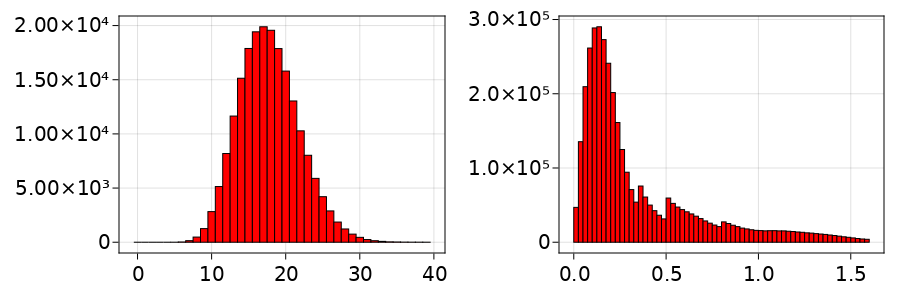

In [259]:
@load "out/images/ewald/1EJG/params.jld2" object N wavelength
# rmask = [0.25, 0.4, 0.7]
# nmask = [3, 1, 3]
rmask = [0.35, 0.5, 0.8]
nmask = [1, 2, 2]
kwidth = 0.9
radius = 1.6

files = glob("out/images/ewald/1EJG/1EJG*.jld2")[1:100]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files));

object = [nph.smoothen(object, kwidth)]
lfs = load("jobs/crambin2/out/stage3.jld2", "state").configuration[1]

proposers = (nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
    nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
    nph.WidthProposer(0.001)), 1
)),)

state = nph.Annealer(([0.1nph.randomAtomVolume(92, 1.2, 30)], [1.0]), proposers, temperature = 1e5, thalf = 1e5, histstep = 100)
targetTemp = 1.0
totalsteps = nph.remainingSteps(state)

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 89)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);

@save "jobs/crambin/stage4.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

## Stage 5

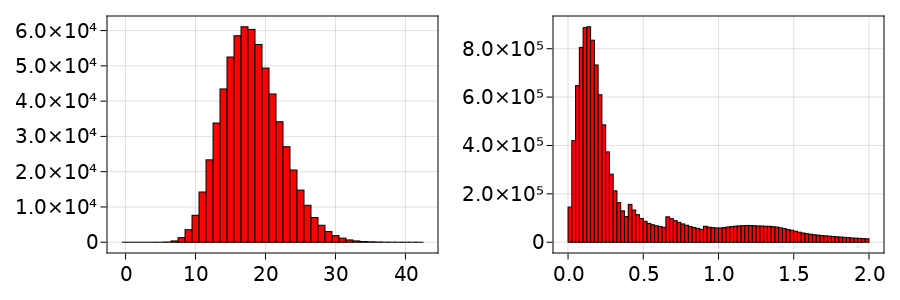

In [130]:
@load "out/images/ewald/1EJG/params.jld2" object N wavelength
rmask = [0.45, 0.9]
nmask = [2, 4]
rmask = [0.4, 0.65, 0.9]
nmask = [1, 1, 3]
kwidth = 0.5
radius = 2.0

files = glob("out/images/ewald/1EJG/1EJG*.jld2")[1:100]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files));

object = [nph.smoothen(object, kwidth)]
lfs = load("jobs/crambin2/out/stage4.jld2", "state").configuration[1]

proposers = (nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
    nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
    nph.WidthProposer(0.001)), 1
)),)

configuration = ([0.1nph.randomAtomVolume(184, 1.0, 30)], [1.0])
for i in 1:100
    configuration = nph.neighbor(proposers[1], configuration)
end
state = nph.Annealer(configuration, proposers, temperature = 1e3, thalf = 2e5, histstep = 100)
targetTemp = 1.0
totalsteps = nph.remainingSteps(state) * 3 ÷ 2

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 89)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);

@save "jobs/crambin2/stage5.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

## Stage 6

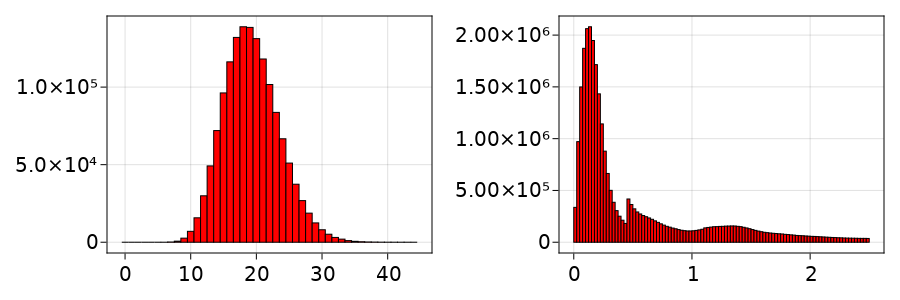

In [463]:
@load "out/images/ewald/1EJG/params.jld2" object N wavelength
rmask = [0.45, 1.1]
nmask = [3, 3]
kwidth = 0.0
radius = 2.5

files = glob("out/images/ewald/1EJG/1EJG*.jld2")[1:100]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files));

object = [nph.smoothen(object, kwidth)]
lfs = load("jobs/crambin2/out/stage5.jld2", "state").configuration[1]

proposers = (nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
    nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
    nph.WidthProposer(0.0005)), 1
)),)

configuration = ([0.1nph.randomAtomVolume(368, 0.7, 30)], [1.0])
for i in 1:100
    configuration = nph.neighbor(proposers[1], configuration)
end
state = nph.Annealer(configuration, proposers, temperature = 1e1, thalf = 5e5, histstep = 100)
targetTemp = 1.0
totalsteps = nph.remainingSteps(state) * 3 ÷ 2

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 89)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);

@save "jobs/crambin2/stage6.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

# Dipeptide

## Stage 1

In [ ]:
@load "out/images/conformations/dipeptide/params.jld2" objs N wavelength
rmask = Float64[0.9, 1.3]
nmask = Int[4, 4]
kwidth = 0.5
radius = 2.0

files = glob("out/images/conformations/dipeptide/dipeptide*.jld2")[1:1]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files));

object = nph.smoothen.(rand(objs, 100), kwidth)
n = 2
lfs = fill(nph.AtomVolume(1, 2.3, 30), n)

priors = Erlang(40, 1 / 8 / 40)
proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
        nph.WidthProposer(0.001)), 1)),
    fill(nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(priors), 2), 
            steplambda = 1.001, stepmax = 0.1), 5)...,
)

configuration = ([0.01nph.randomAtomVolume(5, 1.0, 30) for i in 1:n], normalize(ones(n), 1))

state = nph.Annealer(configuration, proposers, temperature = 1e3, thalf = 1e3)
targetTemp = 1e-3
totalsteps = nph.remainingSteps(state, targetTemp = targetTemp) * 3

npercircle = 32
rotations, rotationWeights = nph.rotationGrid(precision = 23)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.05, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);

@save "jobs/conformations/dipeptide_weighted/stage1.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.05:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

## Stage 2

In [14]:
@load "out/images/conformations/dipeptideN/params.jld2" objs N wavelength
# rmask = Float64[1.3, 2.0, 2.7]
# nmask = Int[3, 2, 2]
rmask = Float64[]
nmask = Int[]
kwidth = 0.0
radius = 4.0

files = glob("out/images/conformations/dipeptideN/dipeptideN*.jld2")[1:1]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files));

object = nph.smoothen.(rand(objs, 100), kwidth)
lfs, lws = load("jobs/conformations/dipeptide_weighted/out/stage1.jld2", "state").configuration
lfs = repeat(lfs, inner = 4)
lws = normalize(repeat(lws, inner = 4), 1)
n = length(lfs)

priors = Erlang.(40, lws ./ 40)
proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
        nph.WidthProposer(0.001)), 1)),
    fill(nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(priors), 2), 
            steplambda = 1.001, stepmax = 0.1), 1)...,
)

configuration = ([0.01nph.randomAtomVolume(10, 0.65, 10) for i in 1:n], normalize(ones(n), 1))

state = nph.Annealer(configuration, proposers, temperature = 1e3, thalf = 5e3)
targetTemp = 1e-1
totalsteps = nph.remainingSteps(state, targetTemp = targetTemp)

npercircle = 32
rotations, rotationWeights = nph.rotationGrid(precision = 35)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.05, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);

for i in 1:10
    @save "jobs/conformations/dipeptide_weighted/stage2_rep$(i).jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps
end

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.05:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

Progress: 100%|███████████████████████████| Time: 0:00:04 ( 4.53 μs/it)
  selected:  1,000,000 = 100.0%
  total:     1,000,000


# Chignolin

## Stage 1

In [137]:
@load "out/images/conformations/5awl/params.jld2" objs N wavelength
rmask = Float64[]
nmask = Int[]
kwidth = 2.5
radius = 0.7

files = glob("out/images/conformations/5awl/5awl*.jld2")[1:1]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files), nselect = 10000);

object = nph.smoothen.(rand(objs, 100), kwidth)
lfs = fill(nph.AtomVolume(1, 10.0, 30), 2)

priors = Erlang(20, 0.5 / 20)
proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
        nph.WidthProposer(0.001)), 1)),
    fill(nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(priors), 2), 
            steplambda = 1.001, stepmax = 0.1), 5)...,
)

state = nph.Annealer(([0.1nph.randomAtomVolume(5, 3.0, 10)], fill(0.5, 2)), proposers, temperature = 1e4, tlambda = 2^(-1/1e3))
targetTemp = 1e-3
totalsteps = nph.remainingSteps(state) * 3 ÷ 2

npercircle = 32
rotations, rotationWeights = nph.rotationGrid(precision = 23)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.01, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);


@save "jobs/conformations/5awl_weighted/stage1.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

Progress: 100%|███████████████████████████| Time: 0:00:05 ( 0.54 ms/it)
  selected:  10,000 = 99.9%
  total:     10,011


## Stage 2

In [244]:
@load "out/images/conformations/5awl/params.jld2" objs N wavelength
rmask = [0.4, 0.6]
nmask = [2, 2]
kwidth = 1.5
radius = 1.0

files = glob("out/images/conformations/5awl/5awl*.jld2")[1:11]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files), nselect = 100000);

object = nph.smoothen.(rand(objs, 100), kwidth)
lfs = repeat(load("jobs/conformations/5awl_weighted/out/stage1.jld2", "state").configuration[1], inner = 2)
lfws = repeat(load("jobs/conformations/5awl_weighted/out/stage1.jld2", "state").configuration[2], inner = 2) ./ 2

priors = Erlang.(20, lfws ./ 20)
proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
        nph.WidthProposer(0.001)), 1)),
    fill(nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(priors), 2), 
            steplambda = 1.001, stepmax = 0.1), 5)...,
)

state = nph.Annealer(([0.1nph.randomAtomVolume(10, 2.0, 10) for i in 1:4], lfws), proposers, temperature = 1e4, tlambda = 2^(-1/1e3))
targetTemp = 1e-3
totalsteps = nph.remainingSteps(state) * 3 ÷ 2

npercircle = 32
rotations, rotationWeights = nph.rotationGrid(precision = 23)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.01, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);


@save "jobs/conformations/5awl_weighted/stage2.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.025:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

Progress: 100%|███████████████████████████| Time: 0:00:40 ( 3.74 μs/it)
  selected:  100,000 = 0.915%
  total:     10,931,255


## Stage 3

Progress: 100%|███████████████████████████| Time: 0:00:38 ( 3.88 μs/it)
  selected:  149,852 = 1.5%
  total:     10,000,000


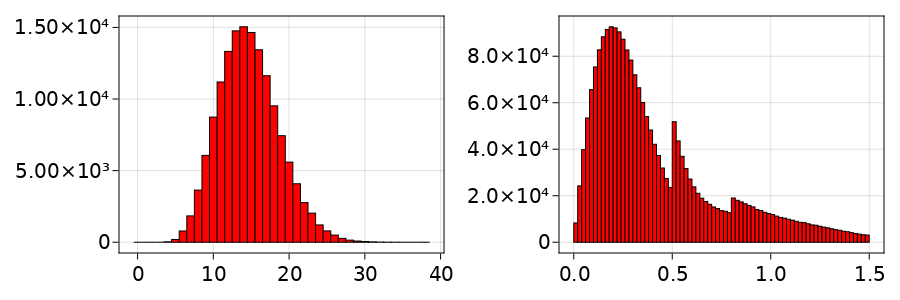

In [229]:
@load "out/images/conformations/5awl/params.jld2" objs N wavelength
rmask = [0.5, 0.8]
nmask = [2, 2]
kwidth = 1.0
radius = 1.5

files = glob("out/images/conformations/5awl/5awl*.jld2")[1:10]
allimages = Iterators.flatten(imap(nph.loadImages, files))
kernel = nph.avKernel(kwidth)
imfilter = image -> [p for p in image if kernel(norm(p)) > rand()]
images = nph.selectImages(imap(imfilter, allimages), rmask, nmask, radius = radius, total = 10^6 * length(files));

object = nph.smoothen.(rand(objs, 100), kwidth)
lfstate = load("jobs/conformations/5awl_weighted/out/stage2.jld2", "state").configuration
lfs = lfstate[1][[1, 1, 2, 2, 3, 4]]
lfws = lfstate[2][[1, 1, 2, 2, 3, 4]] .* 0.5 .* [1, 1, 1, 1, 2, 2]

priors = Erlang.(40, lfws / 40)
proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(
        nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
        nph.WidthProposer(0.001)), 1)),
    fill(nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(priors), 2), 
            steplambda = 1.001, stepmax = 0.1), 5)...,
)

state = nph.Annealer(([0.1nph.randomAtomVolume(20, 1.5, 10) for i in 1:6], fill(0.5, 6)), proposers, temperature = 1e3, thalf = 1e4)
targetTemp = 1e-3
totalsteps = nph.remainingSteps(state, targetTemp = targetTemp)

npercircle = 64
rotations, rotationWeights = nph.rotationGrid(precision = 89)
pixels, pixelWeights = nph.weightedEwaldGrid(qstep = 0.02, qmax = radius, npercircle = npercircle, wavelength = 2.5)
integrationData = (; rotations, pixels, npercircle, pixelWeights, rotationWeights);


@save "jobs/conformations/5awl_weighted/stage3.jld2" object images N lfs state integrationData rmask nmask targetTemp kwidth totalsteps

cairo(); fig = Figure(resolution = (900, 300))
hist(fig[1,1], length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
hist(fig[1,2], norm.(reduce(vcat, images)), bins=0:0.02:radius, color=:red, strokewidth=1, strokecolor=:black)
fig